In [1]:
import torch
import timm
import numpy as np
import pandas as pd
import os
import math
from einops import repeat, rearrange
from einops.layers.torch import Rearrange
from torchvision.transforms import ToTensor, Compose, Normalize
from timm.models.layers import trunc_normal_
from timm.models.vision_transformer import Block
import anndata as ad
from sklearn.model_selection import train_test_split
import time
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.nn.parallel import DataParallel
from dataloader import *
from stage1 import *

/home/dm/anaconda3/envs/attention/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class Config(object):
    """para"""
    def __init__(self):
        self.device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')  
        self.dropout = 0.1                                    
        self.num_classes = 10                                             
        self.batch_size = 128                                       
        self.lr = 5e-4                      
        self.encoder_layer = 6
        self.encoder_head = 2
        self.decoder_layer = 4
        self.decoder_head = 2
        self.mask_ratio = 0.15        
        self.omics_tokens = 4000 ##omics cells
        self.omic_genecomponent = 400 ##channel        
        self.emb_gene = 10
        
        self.mask_ratio1 = 0.15        
        self.omics_tokens1 = 14 ##omics proteins
        self.omic_genecomponent1 =14 ##channel
        self.emb_gene1 = 1 
        
        self.emb_dim = 128       
        self.total_epoch = 500
        self.warmup_epoch = 10

config = Config()
model = Omics_attention(config).to(config.device) ######stage1
#model = DataParallel(model)

In [3]:
from stage2 import *
from dataloaderwithlabel import *
config = Config()
#model = model.half()
model = Omics_Classifier(config).to(config.device)
#model = DataParallel(model)

In [4]:
# save best paras
#model = DataParallel(model)
#model.load_state_dict(torch.load('/mnt/sdb/dmengsave/savebestmodel/pbmc10k_cross_finetune_best_model.pth'),strict=False)

<All keys matched successfully>

In [6]:
omic1 = torch.load('../dataset/RNA-seq/ifnb_rna_rpkm_normalized.pth')
labels = pd.read_csv('../dataset/RNA-seq/ifnb/ifnb_label.csv')
labels = labels['x']
labels = np.array(labels)
labels[labels == 13] = 0

config = Config()
##exp
train_dataset,val_dataset,y_train,y_test = train_test_split(omic1,labels,test_size=0.7, random_state=42)
###second split,just 30 percent data to finetune
train_dataset,val_dataset,y_train,y_test = train_test_split(train_dataset,y_train,test_size=0.1, random_state=42)
train_dataset = train_dataset.to(torch.float).to(config.device)
val_dataset = val_dataset.to(torch.float).to(config.device)
y_train = torch.tensor(y_train, dtype=torch.long).to(config.device)
y_test = torch.tensor(y_test, dtype=torch.long).to(config.device)

multi_modal_trian_dataset = SingleModalDataset(train_dataset,y_train)
multi_modal_test_dataset = SingleModalDataset(val_dataset,y_test)

train_dataloader = torch.utils.data.DataLoader(multi_modal_trian_dataset, 128, shuffle=True,num_workers=0)
val_dataloader = torch.utils.data.DataLoader(multi_modal_test_dataset, 128, shuffle=False,num_workers=0)


In [8]:
###stage3
from stage3 import *
config = Config()
model = Omics_Pred(config).to(config.device)

In [9]:
#############training
early_stopping_patience = 5  
best_val_loss = float('inf')  
no_improvement_count = 0
##loss
lossfun = torch.nn.CrossEntropyLoss()
acc_fn = lambda logit, label: torch.mean((logit.argmax(dim=-1) == label).float())

#model = Omics_Classifier(config).to(config.device)
#model = DataParallel(model)
if __name__ == '__main__':
    
        batch_size = config.batch_size
        load_batch_size = 128
        assert batch_size % load_batch_size == 0
        steps_per_update = batch_size // load_batch_size

        optim = torch.optim.AdamW(model.parameters(), lr=config.lr * config.batch_size / 256, betas=(0.9, 0.999), weight_decay=1e-4)
        lr_func = lambda epoch: min((epoch + 1) / (config.warmup_epoch + 1e-8), 0.5 * (math.cos(epoch / config.total_epoch * math.pi) + 1))
        lr_scheduler = torch.optim.lr_scheduler.LambdaLR(optim, lr_lambda=lr_func, verbose=True)

        best_val_acc = 0
        step_count = 0
        optim.zero_grad()
        for e in range(config.total_epoch):
            model.train()
            train_losses = []
            train_acces  = []
            for tk in tqdm(iter(train_dataloader)):
                #print(train_dataset['mod1'].shape)
                step_count += 1
                
                train_logits,final_results = model(tk['mod1'])
                #print(train_logits.shape)
                #print(final_results.shape)
                train_loss = lossfun(train_logits,tk['label'])
                train_acc = acc_fn(train_logits,tk['label'])
                train_loss.backward()
                if step_count % steps_per_update == 0:
                    optim.step()
                    optim.zero_grad()
                train_losses.append(train_loss.item())
                train_acces.append(train_acc.item())
            lr_scheduler.step()
            avg_train_loss = sum(train_losses) / len(train_losses)
            avg_train_acc = sum(train_acces) / len(train_acces)
            print(f'In epoch {e}, average training loss is {avg_train_loss}, average training acc is {avg_train_acc}.')

            model.eval()
            with torch.no_grad():
                val_losses = []
                val_acces = []
                for td in tqdm(iter(val_dataloader)):
                    val_logits,final_results2= model(td['mod1'])
                    
                    #td['label'] = td['label'].to(torch.long)
                    val_loss = lossfun(val_logits,td['label'])
                    val_acc = acc_fn(val_logits,td['label'])
                    val_losses.append(val_loss.item())
                    val_acces.append(val_acc.item())
                avg_val_loss = sum(val_losses) / len(val_losses)
                avg_val_acc = sum(val_acces) / len(val_acces)
                print(f'In epoch {e}, average validation loss is {avg_val_loss}, average validation acc is {avg_val_acc}.')  

        # 
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                no_improvement_count = 0  #
                print(f'Saving best model with loss {best_val_loss} at epoch {e}!')

                # save best paras
                #torch.save(model.state_dict(), f'/mnt/sdb/dmengsave/savebestmodel/pbmc5k_cross_fintune_best_model.pth')  # 
            else:
                no_improvement_count += 1

            # np.save('trloss.npy', train_losses[0])
            # np.save('valloss.npy', val_losses[0])
            if no_improvement_count >= early_stopping_patience:
                print(f'No improvement in validation loss for {early_stopping_patience} epochs. Early stopping!')
                break  # 

Adjusting learning rate of group 0 to 2.5000e-05.


100%|██████████| 30/30 [00:03<00:00,  9.70it/s]


Adjusting learning rate of group 0 to 5.0000e-05.
In epoch 0, average training loss is 2.3519294023513795, average training acc is 0.24686333934466045.


100%|██████████| 4/4 [00:00<00:00, 53.89it/s]


In epoch 0, average validation loss is 1.9395968317985535, average validation acc is 0.3489583358168602.
Saving best model with loss 1.9395968317985535 at epoch 0!


100%|██████████| 30/30 [00:02<00:00, 14.87it/s]


Adjusting learning rate of group 0 to 7.5000e-05.
In epoch 1, average training loss is 1.6860071659088134, average training acc is 0.4821400801340739.


100%|██████████| 4/4 [00:00<00:00, 53.99it/s]


In epoch 1, average validation loss is 1.4342674314975739, average validation acc is 0.4991319477558136.
Saving best model with loss 1.4342674314975739 at epoch 1!


100%|██████████| 30/30 [00:02<00:00, 14.86it/s]


Adjusting learning rate of group 0 to 1.0000e-04.
In epoch 2, average training loss is 1.07568199634552, average training acc is 0.6923041045665741.


100%|██████████| 4/4 [00:00<00:00, 54.36it/s]


In epoch 2, average validation loss is 0.6789566576480865, average validation acc is 0.8205295205116272.
Saving best model with loss 0.6789566576480865 at epoch 2!


100%|██████████| 30/30 [00:02<00:00, 14.83it/s]


Adjusting learning rate of group 0 to 1.2500e-04.
In epoch 3, average training loss is 0.5374389549096426, average training acc is 0.8777440905570983.


100%|██████████| 4/4 [00:00<00:00, 54.22it/s]


In epoch 3, average validation loss is 0.47418709844350815, average validation acc is 0.8693576455116272.
Saving best model with loss 0.47418709844350815 at epoch 3!


100%|██████████| 30/30 [00:02<00:00, 14.81it/s]


Adjusting learning rate of group 0 to 1.5000e-04.
In epoch 4, average training loss is 0.3110218718647957, average training acc is 0.9474891165892283.


100%|██████████| 4/4 [00:00<00:00, 53.22it/s]


In epoch 4, average validation loss is 0.43381740152835846, average validation acc is 0.8743489533662796.
Saving best model with loss 0.43381740152835846 at epoch 4!


100%|██████████| 30/30 [00:02<00:00, 14.80it/s]


Adjusting learning rate of group 0 to 1.7500e-04.
In epoch 5, average training loss is 0.1782134361565113, average training acc is 0.9760416666666667.


100%|██████████| 4/4 [00:00<00:00, 53.89it/s]


In epoch 5, average validation loss is 0.3631815128028393, average validation acc is 0.8830295205116272.
Saving best model with loss 0.3631815128028393 at epoch 5!


100%|██████████| 30/30 [00:02<00:00, 14.80it/s]


Adjusting learning rate of group 0 to 2.0000e-04.
In epoch 6, average training loss is 0.10275456483165422, average training acc is 0.99296875.


100%|██████████| 4/4 [00:00<00:00, 54.92it/s]


In epoch 6, average validation loss is 0.3459540717303753, average validation acc is 0.9116753488779068.
Saving best model with loss 0.3459540717303753 at epoch 6!


100%|██████████| 30/30 [00:02<00:00, 14.76it/s]


Adjusting learning rate of group 0 to 2.2500e-04.
In epoch 7, average training loss is 0.06330507372816403, average training acc is 0.996875.


100%|██████████| 4/4 [00:00<00:00, 54.69it/s]


In epoch 7, average validation loss is 0.31730732694268227, average validation acc is 0.9136284738779068.
Saving best model with loss 0.31730732694268227 at epoch 7!


100%|██████████| 30/30 [00:02<00:00, 14.75it/s]


Adjusting learning rate of group 0 to 2.4980e-04.
In epoch 8, average training loss is 0.04113415392736594, average training acc is 0.99921875.


100%|██████████| 4/4 [00:00<00:00, 55.07it/s]


In epoch 8, average validation loss is 0.3319842517375946, average validation acc is 0.9027777761220932.


100%|██████████| 30/30 [00:02<00:00, 14.75it/s]


Adjusting learning rate of group 0 to 2.4975e-04.
In epoch 9, average training loss is 0.0286871741215388, average training acc is 0.9997395833333333.


100%|██████████| 4/4 [00:00<00:00, 55.03it/s]


In epoch 9, average validation loss is 0.3362823389470577, average validation acc is 0.9008246511220932.


100%|██████████| 30/30 [00:02<00:00, 14.72it/s]


Adjusting learning rate of group 0 to 2.4970e-04.
In epoch 10, average training loss is 0.02090806538860003, average training acc is 1.0.


100%|██████████| 4/4 [00:00<00:00, 54.79it/s]


In epoch 10, average validation loss is 0.34561843797564507, average validation acc is 0.9047309011220932.


100%|██████████| 30/30 [00:02<00:00, 14.70it/s]


Adjusting learning rate of group 0 to 2.4964e-04.
In epoch 11, average training loss is 0.016612353858848412, average training acc is 1.0.


100%|██████████| 4/4 [00:00<00:00, 54.27it/s]


In epoch 11, average validation loss is 0.36836930364370346, average validation acc is 0.8988715261220932.


100%|██████████| 30/30 [00:02<00:00, 14.65it/s]


Adjusting learning rate of group 0 to 2.4958e-04.
In epoch 12, average training loss is 0.013527422832945982, average training acc is 1.0.


100%|██████████| 4/4 [00:00<00:00, 52.90it/s]

In epoch 12, average validation loss is 0.35743675008416176, average validation acc is 0.8988715261220932.
No improvement in validation loss for 5 epochs. Early stopping!


In [16]:
# save best paras
#torch.save(model.state_dict(), f'/mnt/sdb/dmengsave/savebestmodel/ifnb_pred_best_model.pth') 

In [10]:
val_acc = acc_fn(val_logits,td['label'])
val_acc

tensor(0.8611, device='cuda:1')

In [11]:
#model.half()
tensor1 = omic1.to(torch.float32).to(config.device)
#tensor2 = omic2.to(torch.float32).to(config.device)
model.eval()
with torch.no_grad():
    logits,finals = model(tensor1)
##umap
fin = finals.cpu().numpy()
fin.shape

(13999, 64)

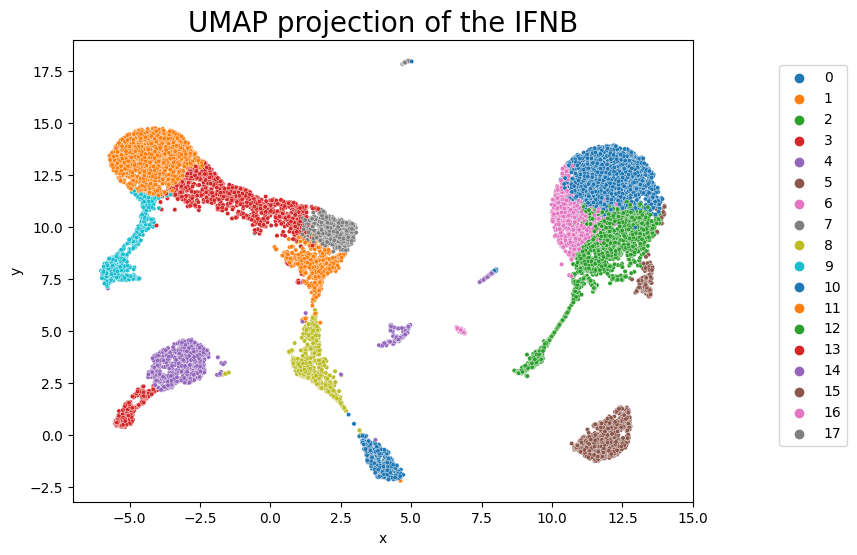

In [12]:
from umappre import *
import umap
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
# community detection
adj_matrix = knn_adj_matrix(fin)
y_pred = RunLeiden(adj_matrix)
##kcluster
#y_pred = RunSpectral(adj_matrix, k=14)
reducer = umap.UMAP()
embedding = reducer.fit_transform(fin)
#label = np.array(eval_labels).reshape(-1, 1)
df = pd.DataFrame({'x': pd.Series(embedding[:, 0]), 'y': pd.Series(embedding[:, 1]), 'label': y_pred})
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='x', y='y', hue='label', s=10,palette = sns.color_palette(mpl.colors.TABLEAU_COLORS ,len(set(y_pred))),)
plt.title('UMAP projection of the IFNB', fontsize=20)
plt.legend(bbox_to_anchor=(1.05, -0), loc=3, borderaxespad=4)
plt.show()


In [15]:
# from scipy.sparse import csr_matrix, save_npz, load_npz
# sparse_matrix = csr_matrix(adj_matrix)
# save_npz('ifnb_sparse_matrix.npz', sparse_matrix)
# np.save('ifnb_scMMAE_pred_umap_corrd.npy',embedding)
# np.save('ifnb_scMMAE_pred_label.npy',y_pred)

In [15]:
import pandas as pd
from sklearn import metrics
from metric import *
y_test = labels
# calculate metric
metrics_dict = {
    'Mean Average Precision': mean_average_precision(embedding, np.ravel(y_test)),
    'Avg Silhouette Width': avg_silhouette_width(embedding, np.ravel(y_test)),
    'Graph Connectivity': graph_connectivity(embedding, np.ravel(y_test)),
    'ARI': metrics.adjusted_rand_score(np.ravel(y_test), np.ravel(y_pred)),
    'NMI': metrics.normalized_mutual_info_score(np.ravel(y_test), np.ravel(y_pred)),
    'FMI': metrics.fowlkes_mallows_score(np.ravel(y_test), np.ravel(y_pred)),
    'Silhouette Coefficient': metrics.silhouette_score(embedding, y_pred, metric='euclidean'),
    'Calinski-Harabaz Index': metrics.calinski_harabasz_score(embedding, y_pred),
    'Davies-Bouldin Index': metrics.davies_bouldin_score(embedding, y_pred),
    'Purity': purity(y_pred, y_test),
    'AMI': metrics.adjusted_mutual_info_score(y_test, y_pred),
    'Homogeneity': metrics.homogeneity_score(y_test, y_pred),
    'Completeness': metrics.completeness_score(y_test, y_pred),
    'V-measure': metrics.v_measure_score(y_test, y_pred),
    'F-measure': F_measure(y_pred, y_test),
    'Jaccard Index': jaccard(y_pred, y_test),
    'Dice Index': Dice(y_pred, y_test)
}

df = pd.DataFrame(list(metrics_dict.items()), columns=['Metric', 'MAEcross_new_ifnb'])###scMMAE
df

,Metric,MAEcross_new_ifnb
0,Mean Average Precision,0.899986
1,Avg Silhouette Width,0.763812
2,Graph Connectivity,0.907747
3,ARI,0.572905
4,NMI,0.762267
5,FMI,0.653552
6,Silhouette Coefficient,0.481933
7,Calinski-Harabaz Index,39000.434476
8,Davies-Bouldin Index,0.845508
9,Purity,0.908708


In [18]:
####旧模型预测的
import pandas as pd
from sklearn import metrics
# 计算各种聚类指标
metrics_dict = {
    'Mean Average Precision': mean_average_precision(embedding, np.ravel(y_test)),
    'Avg Silhouette Width': avg_silhouette_width(embedding, np.ravel(y_test)),
    'Graph Connectivity': graph_connectivity(embedding, np.ravel(y_test)),
    'ARI': metrics.adjusted_rand_score(np.ravel(y_test), np.ravel(y_pred)),
    'NMI': metrics.normalized_mutual_info_score(np.ravel(y_test), np.ravel(y_pred)),
    'FMI': metrics.fowlkes_mallows_score(np.ravel(y_test), np.ravel(y_pred)),
    'Silhouette Coefficient': metrics.silhouette_score(embedding, y_pred, metric='euclidean'),
    'Calinski-Harabaz Index': metrics.calinski_harabasz_score(embedding, y_pred),
    'Davies-Bouldin Index': metrics.davies_bouldin_score(embedding, y_pred),
    'Purity': purity(y_pred, y_test),
    'AMI': metrics.adjusted_mutual_info_score(y_test, y_pred),
    'Homogeneity': metrics.homogeneity_score(y_test, y_pred),
    'Completeness': metrics.completeness_score(y_test, y_pred),
    'V-measure': metrics.v_measure_score(y_test, y_pred),
    'F-measure': F_measure(y_pred, y_test),
    'Jaccard Index': jaccard(y_pred, y_test),
    'Dice Index': Dice(y_pred, y_test)
}

df = pd.DataFrame(list(metrics_dict.items()), columns=['Metric', 'MAEcross_pbmc5k'])
df

,Metric,MAEcross_pbmc5k
0,Mean Average Precision,0.819583
1,Avg Silhouette Width,0.694580
2,Graph Connectivity,0.827314
3,ARI,0.601147
4,NMI,0.749675
5,FMI,0.643869
6,Silhouette Coefficient,0.518221
7,Calinski-Harabaz Index,12430.890854
8,Davies-Bouldin Index,0.589033
9,Purity,0.833250


In [16]:
#df.to_csv('/home/dm/work/reappear/metric_results/scMMAE_ifnb_cluster_metrics.csv', index=False)

In [21]:
eval_omic1 = torch.load('/mnt/sdb/dmengsave/proteomics/spleen_lymph_206/spleen_lymph_206_rna_cpm_normalized.pth')
eval_omic2 = torch.load('/mnt/sdb/dmengsave/proteomics/spleen_lymph_206/spleen_lymph_206_clred.pth')
eval_labels = np.load('/mnt/sdb/dmengsave/proteomics/spleen_lymph_206/spleen_lymph_206_label.npy')
eval_omic1.shape,eval_omic2.shape 

(torch.Size([15820, 1, 4000]), torch.Size([15820, 1, 110]))

In [25]:
#########pred new data
model.half()
tensor1 = eval_omic1.to(torch.float16).to(config.device)
tensor2 = eval_omic2.to(torch.float16).to(config.device)
model.eval()
with torch.no_grad():
    omics_patches1,omics_patches2, mask1,mask2, all_cls1, all_cls2 = model(tensor1,tensor2)

In [26]:
fin = ((all_cls1[0]+all_cls2[0])/2).cpu().numpy()
fin.shape

(15820, 128)

In [27]:
y_test = torch.tensor(eval_labels).to(torch.long)

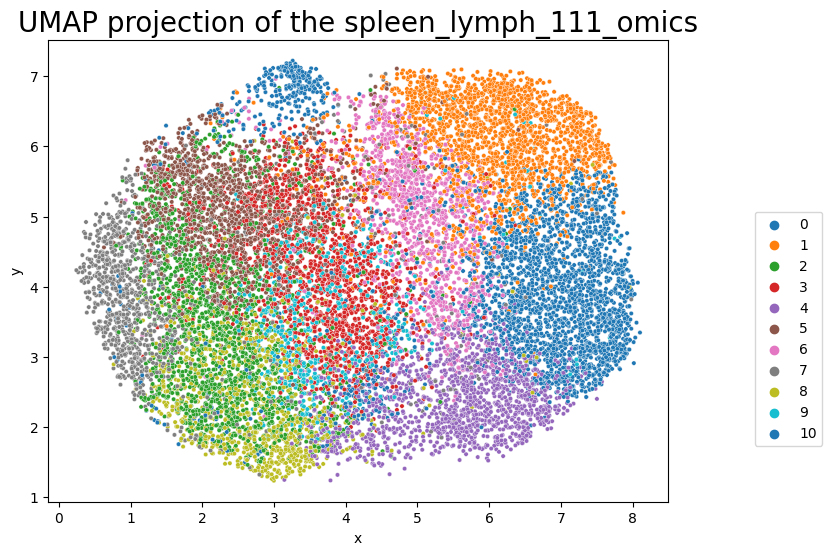

In [16]:
    
from umappre import *
import umap
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from sklearn.manifold import TSNE
import pandas as pd
# community detection
adj_matrix = knn_adj_matrix(fin)
y_pred = RunLeiden(adj_matrix)
##kcluster
#y_pred = RunSpectral(adj_matrix, k=14)
reducer = umap.UMAP()
embedding = reducer.fit_transform(fin)
#label = np.array(eval_labels).reshape(-1, 1)
df = pd.DataFrame({'x': pd.Series(embedding[:, 0]), 'y': pd.Series(embedding[:, 1]), 'label': y_pred})
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='x', y='y', hue='label', s=10,palette = sns.color_palette(mpl.colors.TABLEAU_COLORS ,len(set(y_pred))),)
plt.title('UMAP projection of the spleen_lymph_111_omics', fontsize=20)
plt.legend(bbox_to_anchor=(1.05, -0), loc=3, borderaxespad=4)
plt.show()

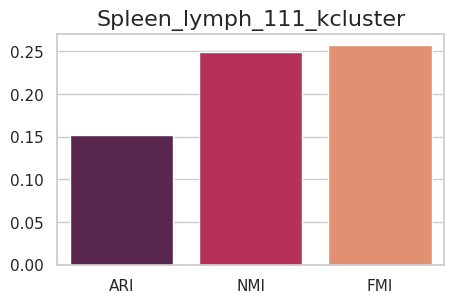

In [17]:
##pretain的直接预测新数据

###NMI
from sklearn.metrics import adjusted_rand_score 
from sklearn.metrics import normalized_mutual_info_score,fowlkes_mallows_score
ARI = adjusted_rand_score(np.ravel(y_test), np.ravel(y_pred))
NMI = normalized_mutual_info_score(np.ravel(y_test), np.ravel(y_pred))
FMI = fowlkes_mallows_score(np.ravel(y_test), np.ravel(y_pred))
categories = ['ARI', 'NMI', 'FMI']
v = [ARI,NMI,FMI]
sns.set(style="whitegrid")  
plt.figure(figsize=(5, 3))  #
sns.barplot(x=categories, y=v, palette="rocket")  
plt.title('Spleen_lymph_111_kcluster', fontsize=16)  
plt.show()